
## Acknowledgements
Special thanks to ChatGPT for providing code snippets and guidance for the implementation of various techniques in this project. 
[OpenAI’s ChatGPT](https://www.openai.com/chatgpt) was instrumental in generating code and answering questions about data analysis and 
visualization.


In [1]:
import numpy as np
import pandas as pd
import os
import warnings
import librosa
#import parselmouth
#from parselmouth.praat import call
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchsummary import summary
from b2aiprep.dataset import VBAIDataset
from b2aiprep.process import Audio, specgram
import IPython.display as Ipd

warnings.filterwarnings("ignore", category=UserWarning, message="PySoundFile failed. Trying audioread instead.")
warnings.filterwarnings("ignore", category=FutureWarning, message="librosa.core.audio.__audioread_load")


/home/legolas/.local/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/legolas/.local/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


# Preparing the dataset

In [2]:
# loading the dataset
dataset = VBAIDataset('./data/bids_with_sensitive_recordings/')
#dataset_sample = VBAIDataset('./data/sample_data/')


### Dataset split
- 80% for training
- 10% for validation
- 10% for testing

In [3]:
participant_df = dataset.load_and_pivot_questionnaire('participant')
all_identities = sorted(participant_df['record_id'].to_numpy().tolist())

N = len(all_identities)
'''
train_identities = set(all_identities[:int(0.8*N)])
val_identities = set(all_identities[int(0.8*N):int(0.9*N)])
test_identities = set(all_identities[int(0.9*N):])
'''

import random
from sklearn.model_selection import train_test_split

train_identities, DT_test_identities = train_test_split(all_identities, test_size=0.15, random_state=123)
val_identities, test_identities = train_test_split(DT_test_identities, test_size=0.5, random_state=123)

print('train:', len(train_identities))
print('val:', len(val_identities))
print('test:', len(test_identities))


train: 151
val: 13
test: 14


### Create PyTorch dataset of all audio features given in the .pt file

In [4]:

qs = dataset.load_questionnaires('recordingschema')
q_dfs = []
for i, questionnaire in enumerate(qs):
    df = dataset.questionnaire_to_dataframe(questionnaire)
    df['dataframe_number'] = i
    q_dfs.append(df)
    i += 1
recordingschema_df = pd.concat(q_dfs)
recordingschema_df = pd.pivot(recordingschema_df, index='dataframe_number', columns='linkId', values='valueString')

person_session_pairs = recordingschema_df[['record_id', 'recording_session_id']].to_numpy().astype(str)
person_session_pairs = np.unique(person_session_pairs, axis=0).tolist()

print('Found {} person/session pairs'.format(len(person_session_pairs)))


Found 204 person/session pairs


In [103]:
class MyAudioDataset(torch.utils.data.Dataset):
    def __init__(self, identities, dataset, person_session_pairs, segment_size=3):
        self.segment_size = segment_size
        
        # Define gender mapping
        self.gender_mapping = {
            'Male gender identity': 0,
            'Female gender identity': 1,
            'no record': 2,
            'Non-binary or genderqueer gender identity': 3
        }
        self.reverse_gender_mapping = {v: k for k, v in self.gender_mapping.items()}

        self.site_mapping = {
            'Mt. Sinai': 0, 
            'VUMC': 1,
            'MIT': 2,
            'USF': 3,
            'WCM': 4
        }

        # Define bins for age ranges and labels
        self.bins = [0, 20, 40, 60, 80, 100]
        self.labels = [0, 1, 2, 3, 4]

        self.reverse_site_mapping = {v: k for k, v in self.site_mapping.items()}
        
        # get age and airway stenosis classification for all subjects
        participant_df = dataset.load_and_pivot_questionnaire('participant')
        demographics_df = dataset.load_and_pivot_questionnaire('qgenericdemographicsschema').drop_duplicates(subset='record_id', keep='first')
        
        age_data = participant_df[['record_id', 'age']].to_numpy()
        site_data = participant_df[['record_id', 'enrollment_institution']].to_numpy()
        
        gender_df = demographics_df[['record_id', 'gender_identity']]
        no_demographics_record = ['2af5afbc-82b1-4656-a203-a8d29b69d3ab', '5201d61d-4b67-482f-bddd-39466e63c4f4']
        new_row_df = pd.DataFrame({'record_id': no_demographics_record, 'gender_identity': ['no record', 'no record']})
        
        gender_data = pd.concat([gender_df, new_row_df], ignore_index=True).to_numpy()

        vocal_fold_paralysis_data = participant_df[['record_id', 'voc_fold_paralysis']].to_numpy()
        
        age_dict = {}
        binned_age_dict = {}
        for person_id, age in age_data:
            binned_age = np.digitize(float(age), self.bins, right=True) - 1
            age_dict[str(person_id)] = float(age)
            binned_age_dict[str(person_id)] = self.labels[binned_age]

        gender_dict = {}
        for person_id, gender in gender_data:
            gender_dict[str(person_id)] = self.gender_mapping.get(str(gender), -1)  # Default to -1 if not found
        
        site_dict = {}
        for person_id, site in site_data:
            site_dict[str(person_id)] = self.site_mapping.get(str(site), -1)  # Default to -1 if not found

        vfp_dict = {}
        for person_id, vfp in vocal_fold_paralysis_data:
            vfp_dict[str(person_id)] = float(vfp)
        
        self.feature_files = []
        self.age = []
        self.binned_age = []
        self.gender = []
        self.site = []
        self.vocal_fold_paralysis = []
        
        for person_id, session_id in person_session_pairs:
            if person_id not in identities:
                continue
            
            audio_features = [str(path) for path in dataset.find_audio_features(person_id, session_id) if "Audio-Check" not in str(path)]
            self.feature_files += audio_features
            self.age += [age_dict[person_id]]*len(audio_features)
            self.binned_age += [binned_age_dict[person_id]]*len(audio_features)
            self.gender += [gender_dict[person_id]]*len(audio_features)
            self.site += [site_dict[person_id]]*len(audio_features)
            self.vocal_fold_paralysis += [vfp_dict[person_id]]*len(audio_features)
        
        assert len(self.feature_files) == len(self.age) == len(self.gender) == len(self.site) == len(self.vocal_fold_paralysis)
        
    def __len__(self):
        return len(self.feature_files)
    
    def map_gender_back(self, gender_numeric):
        return self.reverse_gender_mapping.get(gender_numeric, 'unknown')
        
    def map_site_back(self, site_numeric):
        return self.reverse_site_mapping.get(site_numeric, 'unknown')
        
    def __getitem__(self, idx):
        feature = torch.load(self.feature_files[idx])
        opensmile_feature = feature['opensmile']
        age = self.age[idx]
        gender = self.gender[idx]
        site = self.site[idx]
        binned_age = self.binned_age[idx]
        vfp = self.vocal_fold_paralysis[idx]
        
        return opensmile_feature, age, gender, site, binned_age , vfp


In [104]:
train_dataset = MyAudioDataset(train_identities, dataset, person_session_pairs)
val_dataset = MyAudioDataset(val_identities, dataset, person_session_pairs)
test_dataset = MyAudioDataset(test_identities, dataset, person_session_pairs)
DT_test_dataset = MyAudioDataset(DT_test_identities, dataset, person_session_pairs)

full_dataset = MyAudioDataset(all_identities, dataset, person_session_pairs)

print("Train data size : " , len(train_dataset))
print("Validation data size : ", len(val_dataset))
print("Test data size : ", len(test_dataset))
print("-----------------------")
print("Test set for Decision Tree Algo : ", len(DT_test_dataset))
print("Lenght of full dataset : " , len(full_dataset))


Train data size :  5160
Validation data size :  410
Test data size :  449
-----------------------
Test set for Decision Tree Algo :  859
Lenght of full dataset :  6019


In [105]:
#participant_df = dataset.load_and_pivot_questionnaire('participant')

#print(sorted(list(participant_df.columns)))

print(train_dataset.vocal_fold_paralysis.count(1.0))
print(val_dataset.vocal_fold_paralysis.count(1.0))
print(test_dataset.vocal_fold_paralysis.count(1.0))

920
66
68


# Now let's do the visualization of data!!!

### Preparing the data for the visualization and Decision Tree based functions

In [107]:

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

#audio_dataset = MyAudioDataset(all_identities, dataset, person_session_pairs)

def create_open_smile_df(audio_dataset, include_GAS = True):
    # Extract opensmile features, age, gender, and site
    opensmile_features = []
    ages = []
    genders = []
    sites = []
    vocal_fold_paralysis = []
    GENDERS_org = []
    SITES_org = []
    AGE_binned = []
    
    for i in range(len(audio_dataset)):
        opensmile_feature, age, gender, site, binned_age, vfp = audio_dataset[i]
        opensmile_features.append(opensmile_feature.squeeze())
        ages.append(age)
        genders.append(gender)
        sites.append(site)
        GENDERS_org.append(audio_dataset.map_gender_back(gender))
        SITES_org.append(audio_dataset.map_site_back(site))
        AGE_binned.append(binned_age)
        vocal_fold_paralysis.append(vfp)
    
    # Convert to DataFrame
    opensmile_df = pd.DataFrame(opensmile_features)
    opensmile_df['age'] = ages
    opensmile_df['gender'] = genders
    opensmile_df['site'] = sites
    opensmile_df['GENDER_org'] = GENDERS_org
    opensmile_df['SITE_org'] = SITES_org
    opensmile_df['AGE_bin'] = AGE_binned
    opensmile_df['vocal_fold_paralysis'] = vocal_fold_paralysis
    
    
    # Standardize the opensmile features
    if include_GAS:
        feature_columns = opensmile_df.columns[:-4]
        label_columns = opensmile_df.columns[-4:]
    
    else:
        feature_columns = opensmile_df.columns[:-7]
        label_columns = opensmile_df.columns[-7:]
    
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(opensmile_df[feature_columns])
    
    return opensmile_df, scaled_features, feature_columns, label_columns

opensmile_df, scaled_features, feature_columns, label_columns = create_open_smile_df(full_dataset, include_GAS = 'True')

print(len(list(opensmile_df.columns)))
print(label_columns)
print(len(feature_columns))

#opensmile_df, scaled_features, feature_columns, label_columns = create_open_smile_df(full_dataset, False)

#print(len(list(opensmile_df.columns)))
#print(label_columns)
#print(len(feature_columns))

95
Index(['GENDER_org', 'SITE_org', 'AGE_bin', 'vocal_fold_paralysis'], dtype='object')
91
95
Index(['age', 'gender', 'site', 'GENDER_org', 'SITE_org', 'AGE_bin',
       'vocal_fold_paralysis'],
      dtype='object')
88


# Now let's do decision tree based classifier!!!
## Including Gender, Age, Site as feature 

In [108]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np

def RF_classifier(train_dataset, include_GAS = True, target_column = 'vocal_fold_paralysis'):
    
    opensmile_df_train, scaled_features_train, _ , _ = create_open_smile_df(train_dataset, include_GAS)
    
    X_train = scaled_features_train
    y_train = opensmile_df_train[target_column] 
    
    #Train a RandomForest classifier
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    
    return clf



RF_clf = RF_classifier(train_dataset, include_GAS = True, target_column = 'vocal_fold_paralysis') # age, gender, site, vocal_fold_paralysis

#Creating test data for generating prediction using RF classifier
opensmile_df_test, scaled_features_test, feature_columns , _ = create_open_smile_df(DT_test_dataset,include_GAS = True)
X_test = scaled_features_test
y_test = opensmile_df_test['vocal_fold_paralysis']
predictions = RF_clf.predict(X_test)

### Feature importance (including GAS)

In [109]:
# Get feature importances
feature_importances = RF_clf.feature_importances_
#print(feature_importances.shape)
#print(len(feature_columns))
# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                                           Feature  Importance
90                                            site    0.082539
88                                             age    0.051796
26                                mfcc3_sma3_amean    0.018624
2       F0semitoneFrom27.5Hz_sma3nz_percentile20.0    0.017402
12                    loudness_sma3_percentile20.0    0.016317
..                                             ...         ...
83                      MeanVoicedSegmentLengthSec    0.005349
7    F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope    0.005310
51           F2amplitudeLogRelF0_sma3nz_stddevNorm    0.005160
9   F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope    0.004998
89                                          gender    0.003264

[91 rows x 2 columns]


In [88]:
accuracies = [predictions == y_test]

#print(accuracies)
print(accuracies[0][1] * accuracies[0][857])
print(np.mean(accuracies))

test = [True, False, True, True, False]
print(np.mean(test))

False
0.8451688009313155
0.6


### Different Fairness Metrics

In [124]:

# https://towardsdatascience.com/mitigating-bias-in-ai-with-aif360-b4305d1f88a9

from scipy.stats import chi2_contingency

def fairness_metric(dataset, _opensmile_df_, ground_truth, _predictions_, attribute='gender', calc_chi_square=True):
    
    print("---" , attribute.upper(), "---")
    
    sensitive_attribute = _opensmile_df_[attribute]
    if attribute == 'age':
        sensitive_attribute = _opensmile_df_['AGE_bin']
        
    contingency_table = pd.crosstab(sensitive_attribute, _predictions_, rownames=[attribute], colnames=['Prediction'])
    
    # Compare distributions
    if calc_chi_square:
        chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
        print(f'Chi-Square Statistic: {chi2_stat}, p-value: {p_value}')

    unique_groups = sensitive_attribute.unique()
    favorable_outcome = {}

    def age_map(x):
        labels = ['0-20', '21-40', '41-60', '61-80', '81-100']
        return labels[x]

    if attribute == 'gender':
        map_func = dataset.map_gender_back
    elif attribute == 'site':
        map_func = dataset.map_site_back
    elif attribute == 'age':
        map_func = age_map
        
    accuracies = [_predictions_ == ground_truth]
    for group in unique_groups:
        #group_predictions = _predictions_[sensitive_attribute == group]
        group_predictions = accuracies[0][sensitive_attribute == group]
        group_truth = ground_truth[sensitive_attribute == group]
        
        favorable_outcome[group] = np.mean(group_predictions) # should it be np.count???
        
    most_favorable_group = max(favorable_outcome, key=favorable_outcome.get)
    disparate_impact_ratios = {group: favorable_outcome[group] / favorable_outcome[most_favorable_group] for group in unique_groups}
    
    #Print the disparate impact ratios
    for group, ratio in disparate_impact_ratios.items():
        print(f'Disparate Impact Ratio for Group {map_func(group)}: {ratio}')

    # Plotting the disparate impact ratios
    plt.figure(figsize=(10, 6))
    groups = [map_func(group) for group in unique_groups]
    ratios = [disparate_impact_ratios[group] for group in unique_groups]
    plt.bar(groups, ratios, color=plt.get_cmap('tab10').colors[:len(unique_groups)])
    plt.axhline(y=0.8, color='r', linestyle='--', label='80% Rule Threshold')
    plt.xlabel('Groups')
    plt.ylabel('Disparate Impact Ratio')
    plt.title('Disparate Impact Ratios by Group')
    plt.legend()
    plt.show()


--- GENDER ---
Chi-Square Statistic: 2.2070110304192694, p-value: 0.13738462810981902
Disparate Impact Ratio for Group Female gender identity: 0.9912917926273519
Disparate Impact Ratio for Group Male gender identity: 1.0


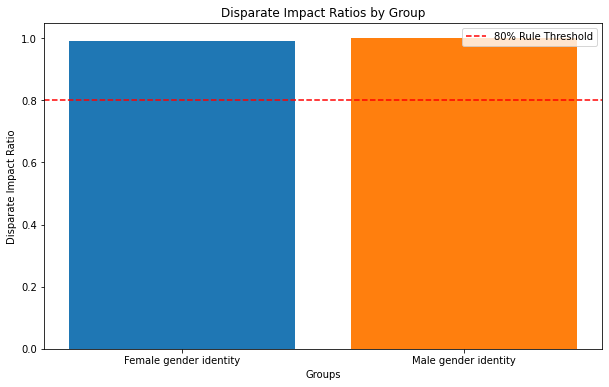


--- SITE ---
Chi-Square Statistic: 24.83712702788789, p-value: 5.424908517500733e-05
Disparate Impact Ratio for Group MIT: 0.9904761904761905
Disparate Impact Ratio for Group WCM: 0.08333333333333333
Disparate Impact Ratio for Group VUMC: 0.6346153846153846
Disparate Impact Ratio for Group USF: 1.0
Disparate Impact Ratio for Group Mt. Sinai: 1.0


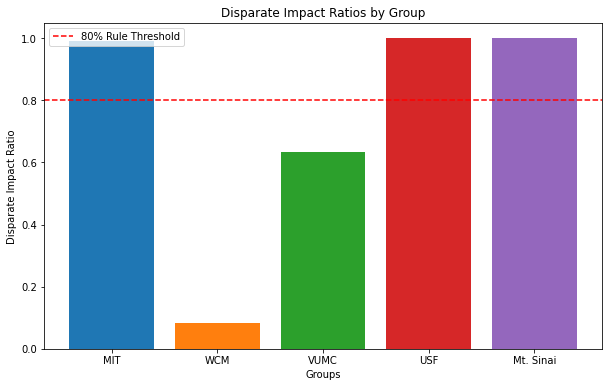


--- AGE ---
Chi-Square Statistic: 9.411796555169673, p-value: 0.051591525616290976
Disparate Impact Ratio for Group 21-40: 0.876984126984127
Disparate Impact Ratio for Group 61-80: 0.6934673366834171
Disparate Impact Ratio for Group 41-60: 0.8762214983713354
Disparate Impact Ratio for Group 81-100: 1.0
Disparate Impact Ratio for Group 0-20: 1.0


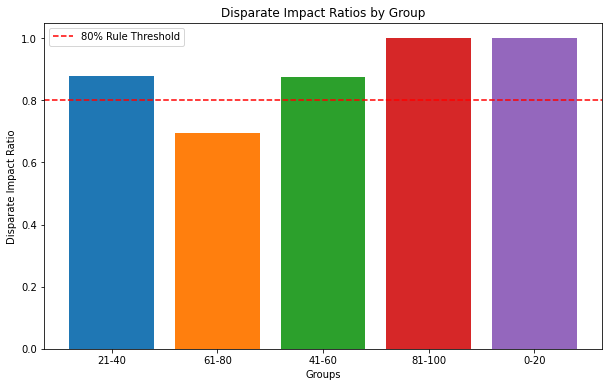

In [125]:
fairness_metric(DT_test_dataset, opensmile_df_test, y_test, predictions, attribute='gender')
print()
fairness_metric(DT_test_dataset, opensmile_df_test, y_test, predictions, attribute='site')
print()
fairness_metric(DT_test_dataset, opensmile_df_test, y_test, predictions, attribute='age')

# Now let's do decision tree based classifier!!!
## W/o Including Gender, Age, Site as feature

In [112]:

#opensmile_df, scaled_features, feature_columns, label_columns = create_open_smile_df(full_dataset, False)
RF_clf = RF_classifier(train_dataset, target_column = 'vocal_fold_paralysis', include_GAS = False) # age, gender, site, vocal_fold_paralysis
#Creating test data for generating prediction using RF classifier
opensmile_df_test, scaled_features_test, feature_columns , _ = create_open_smile_df(DT_test_dataset, False)


In [113]:
print(label_columns)
#print(scaled_features_test.shape)
X_test = scaled_features_test
y_test = opensmile_df_test['vocal_fold_paralysis']
predictions = RF_clf.predict(X_test)
#print(predictions.shape)

Index(['age', 'gender', 'site', 'GENDER_org', 'SITE_org', 'AGE_bin',
       'vocal_fold_paralysis'],
      dtype='object')


### Feature importance (w/o including GAS)

In [114]:
# Get feature importances
feature_importances = RF_clf.feature_importances_
#print(feature_importances.shape)
#print(len(feature_columns))
# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                                          Feature  Importance
2      F0semitoneFrom27.5Hz_sma3nz_percentile20.0    0.019394
26                               mfcc3_sma3_amean    0.019374
12                   loudness_sma3_percentile20.0    0.018316
24                               mfcc2_sma3_amean    0.018159
79                   slopeUV500-1500_sma3nz_amean    0.018039
..                                            ...         ...
43                  F1bandwidth_sma3nz_stddevNorm    0.007085
84                   StddevVoicedSegmentLengthSec    0.006871
7   F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope    0.006551
45          F1amplitudeLogRelF0_sma3nz_stddevNorm    0.006293
50               F2amplitudeLogRelF0_sma3nz_amean    0.006031

[88 rows x 2 columns]


--- GENDER ---
Chi-Square Statistic: 2.2070110304192694, p-value: 0.13738462810981902
Disparate Impact Ratio for Group Female gender identity: 0.9912917926273519
Disparate Impact Ratio for Group Male gender identity: 1.0


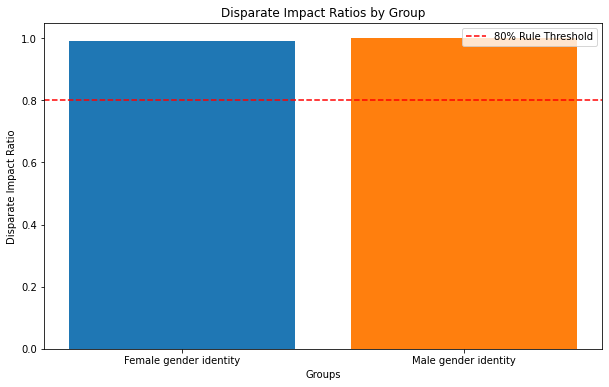


--- SITE ---
Chi-Square Statistic: 24.83712702788789, p-value: 5.424908517500733e-05
Disparate Impact Ratio for Group MIT: 0.9904761904761905
Disparate Impact Ratio for Group WCM: 0.08333333333333333
Disparate Impact Ratio for Group VUMC: 0.6346153846153846
Disparate Impact Ratio for Group USF: 1.0
Disparate Impact Ratio for Group Mt. Sinai: 1.0


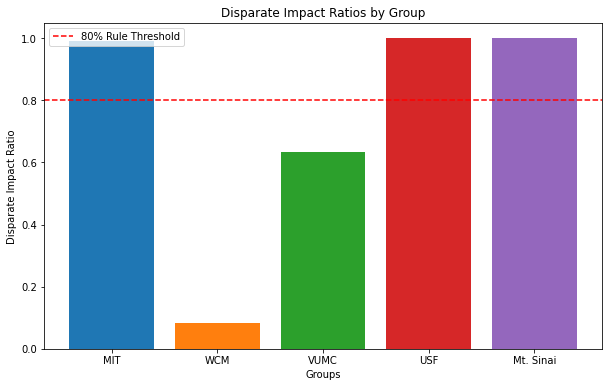


--- AGE ---
Chi-Square Statistic: 9.411796555169673, p-value: 0.051591525616290976
Disparate Impact Ratio for Group 21-40: 0.876984126984127
Disparate Impact Ratio for Group 61-80: 0.6934673366834171
Disparate Impact Ratio for Group 41-60: 0.8762214983713354
Disparate Impact Ratio for Group 81-100: 1.0
Disparate Impact Ratio for Group 0-20: 1.0


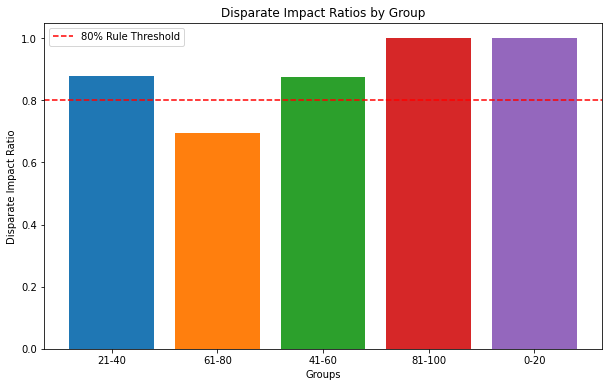

In [126]:
fairness_metric(DT_test_dataset, opensmile_df_test, y_test, predictions, attribute='gender')
print()
fairness_metric(DT_test_dataset, opensmile_df_test, y_test, predictions, attribute='site')
print()
fairness_metric(DT_test_dataset, opensmile_df_test, y_test, predictions,attribute='age')

### Confusion Matrix (IGNORE)

In [127]:
from sklearn.metrics import confusion_matrix

def confusion_matrix(y, predictions, attribute='gender'):

    sensitive_attribute = opensmile_df_test[attribute]
    unique_groups = sensitive_attribute.unique()
    print(len(y[sensitive_attribute == 0]))
    # Initialize a dictionary to hold confusion matrices for each group
    confusion_matrices = {group: confusion_matrix(y[sensitive_attribute == group], predictions[sensitive_attribute == group]) 
                          for group in unique_groups}
    
    # Initialize a list to hold fairness metrics
    fairness_metrics = []

    if attribute == 'gender':
        map_func = DT_test_dataset.map_gender_back
    elif attribute == 'site':
        map_func = DT_test_dataset.map_site_back
    
    # Calculate fairness metrics for each pair of groups
    for i in range(len(unique_groups)):
        for j in range(i + 1, len(unique_groups)):
            group_1 = unique_groups[i]
            group_2 = unique_groups[j]
    
            cm_group_1 = confusion_matrices[group_1]
            cm_group_2 = confusion_matrices[group_2]
    
            # Calculate True Positive Rates for each group
            true_positive_rate_group_1 = cm_group_1[1, 1] / (cm_group_1[1, 0] + cm_group_1[1, 1])
            true_positive_rate_group_2 = cm_group_2[1, 1] / (cm_group_2[1, 0] + cm_group_2[1, 1])
    
            # Calculate Equal Opportunity Difference
            equal_opportunity_difference = abs(true_positive_rate_group_1 - true_positive_rate_group_2)
            fairness_metrics.append((group_1, group_2, equal_opportunity_difference))
            #print(f'Equal Opportunity Difference between Group {group_1} and Group {group_2}: {equal_opportunity_difference}')
    
    # Optional: Print all fairness metrics for all pairs
    print("\nAll Fairness Metrics:")
    for group_1, group_2, eod in fairness_metrics:
        print(f'Equal Opportunity Difference between Group {map_func(group_2)} and Group {map_func(group_1)}: {eod}')

#print(y_test.shape, predictions.shape)
confusion_matrix(y_test, predictions)


260


IndexError: boolean index did not match indexed array along dimension 0; dimension is 599 but corresponding boolean dimension is 5033

### Histogram Comparison (IGNORE)

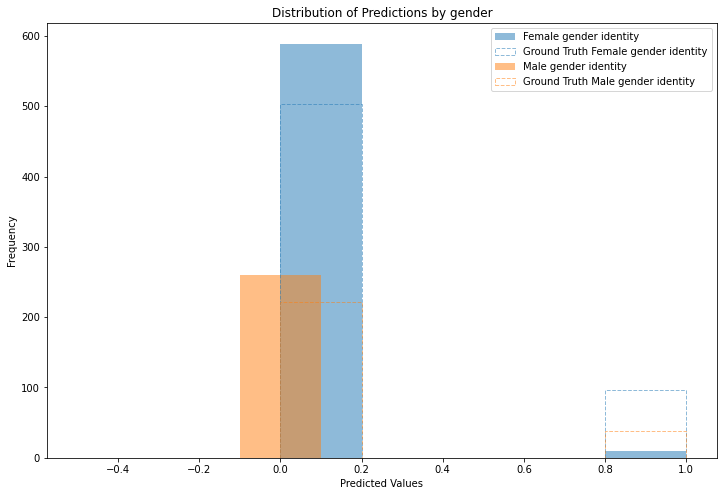

In [65]:

def hist_comp(attribute='gender'):
    sensitive_attribute = opensmile_df_test[attribute]
    
    # Define the unique values in your sensitive attribute
    unique_groups = sensitive_attribute.unique()
    
    # Plot histograms for each group
    plt.figure(figsize=(12, 8))
    
    colors = plt.get_cmap('tab10').colors
    
    for i, group in enumerate(unique_groups):
        group_predictions = predictions[sensitive_attribute == group]
        group_truth = y_test[sensitive_attribute == group]

        if attribute == 'gender':
            map_func = DT_test_dataset.map_gender_back
        elif attribute == 'site':
            map_func = DT_test_dataset.map_site_back
        
        plt.hist(group_predictions, alpha=0.5, label=map_func(group), bins=5, color=colors[i % len(colors)])
        plt.hist(group_truth, alpha=0.5, label=f'Ground Truth {map_func(group)}', bins=5, histtype='step', 
                 linestyle='--', color=colors[i % len(colors)])
    
    plt.legend(loc='upper right')
    plt.xlabel('Predicted Values')
    plt.ylabel('Frequency')
    plt.title('Distribution of Predictions by ' + attribute)
    plt.show()


hist_comp('gender')


### Model explainer using SHAP (IGNORE)

In [ ]:
# https://www.sciencedirect.com/science/article/pii/S0169260721006581#fig0003
# https://datascientest.com/en/shap-what-is-it
# https://shap.readthedocs.io/en/latest/
#https://github.com/shap/shap#citations

import shap

explainer = shap.TreeExplainer(RF_clf)
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test, feature_names=feature_columns)
#shap.force_plot(shap_values, X_test)

## Just Visualization into lower dimension no classifier

### PCA

In [118]:

opensmile_df, scaled_features, feature_columns, label_columns = create_open_smile_df(full_dataset, include_GAS=False)

# Perform PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(scaled_features)

#prepare the data for plotting 2D scatter plot of PCA features
pca_df = pd.DataFrame(pca_result[:,:2], columns=['PC1', 'PC2'])
pca_df = pd.concat([pca_df, opensmile_df[['age', 'GENDER_org', 'SITE_org']].reset_index(drop=True)], axis=1)


##### PCA 2D scatter plot colored by gender

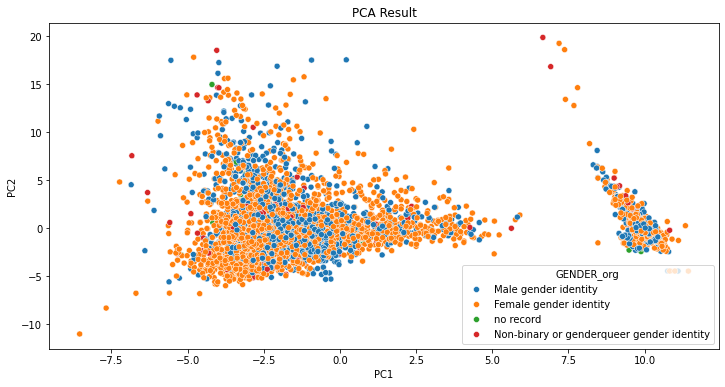

In [119]:

plt.figure(figsize=(12, 6))
#plt.subplot(1, 2, 1)
sns.scatterplot(x='PC1', y='PC2', hue='GENDER_org', data=pca_df)
plt.title('PCA Result')
plt.show()

#print(sns.color_palette())

##### PCA 2D scatter plot colored by age

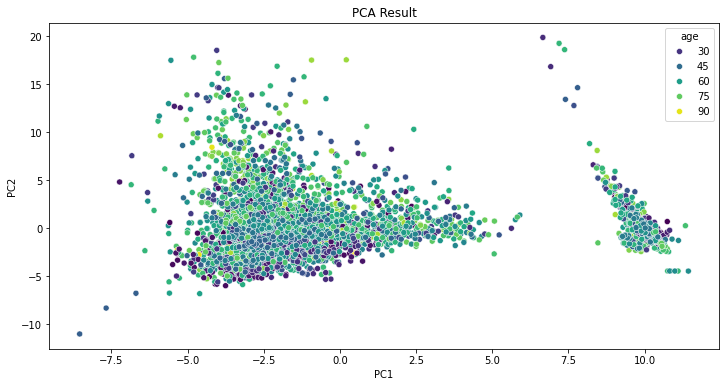

In [117]:
# Plot PCA result
plt.figure(figsize=(12, 6))
#plt.subplot(1, 2, 1)
sns.scatterplot(x='PC1', y='PC2', hue='age', data=pca_df, palette='viridis') #coolwarm, plasma, viridis
plt.title('PCA Result')
plt.show()

##### PCA 2D scatter plot colored by age-bins

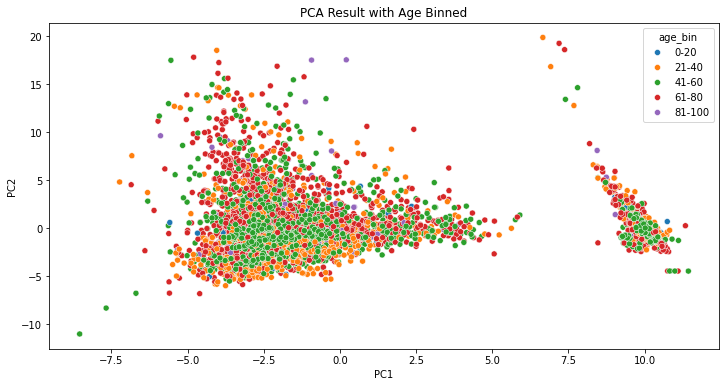

In [48]:

# Define age bins
bins = [0, 20, 40, 60, 80, 100]  # Define bins for age ranges
labels = ['0-20', '21-40', '41-60', '61-80', '81-100']  # Define bin labels
pca_df['age_bin'] = pd.cut(pca_df['age'], bins=bins, labels=labels)

# Plot PCA result with discrete age bins
plt.figure(figsize=(12, 6))
sns.scatterplot(x='PC1', y='PC2', hue='age_bin', data=pca_df)
plt.title('PCA Result with Age Binned')
plt.show()


In [ ]:
print(list(pca_df['age']))

##### PCA 3D scatter plot colored by gender

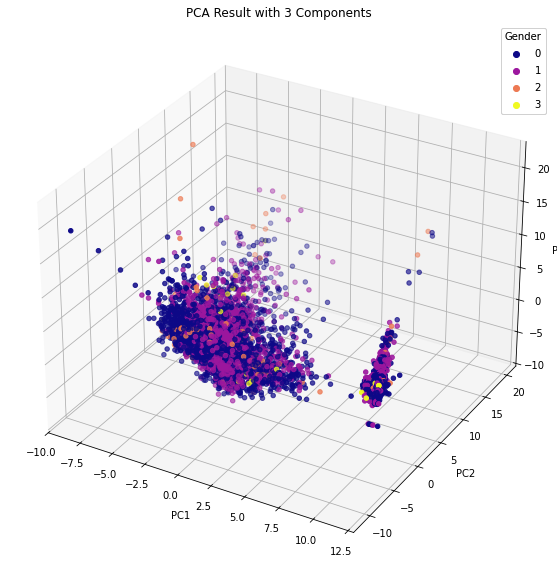

In [49]:

#prepare the data for plotting 2D scatter plot of PCA features
pca_df = pd.DataFrame(pca_result[:,:3], columns=['PC1', 'PC2', 'PC3'])
pca_df = pd.concat([pca_df, opensmile_df[['age', 'GENDER_org', 'SITE_org']].reset_index(drop=True)], axis=1)

#Plot PCA 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
#coolwarm, plasma, viridis
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['GENDER_org'].astype('category').cat.codes, cmap='plasma')

# Add legend
legend1 = ax.legend(*scatter.legend_elements(), title="Gender")
ax.add_artist(legend1)

# Add labels
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('PCA Result with 3 Components')
plt.show()



##### PCA 3D scatter plot colored by age

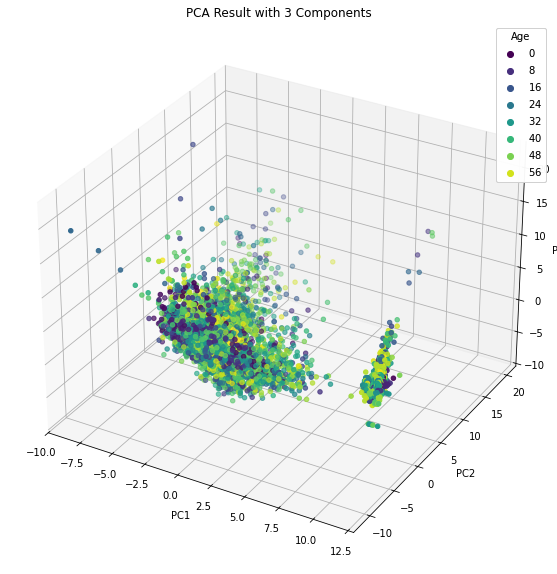

In [50]:

#Plot PCA 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['age'].astype('category').cat.codes, cmap='viridis')

# Add legend
legend1 = ax.legend(*scatter.legend_elements(), title="Age")
ax.add_artist(legend1)

# Add labels
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('PCA Result with 3 Components')
plt.show()

#### t-SNE

In [51]:
# Perform t-SNE
tsne = TSNE(n_components=3, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(scaled_features)

#prepare t-SNE result for 2D scatter plot
tsne_df = pd.DataFrame(tsne_result[:,:2], columns=['TSNE1', 'TSNE2'])
tsne_df = pd.concat([tsne_df, opensmile_df[['age', 'GENDER_org', 'SITE_org']].reset_index(drop=True)], axis=1)



##### t-SNE 2D scatter plot colored by gender

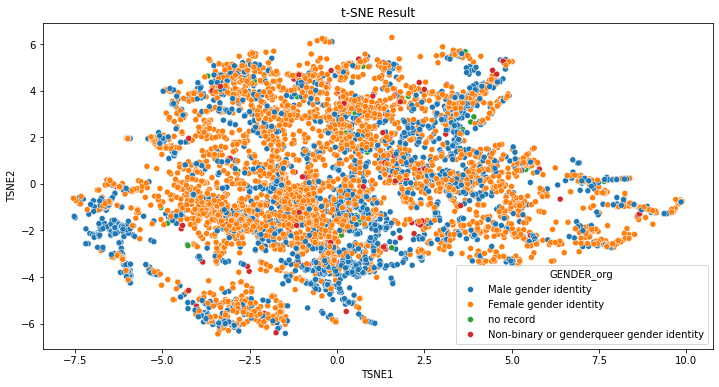

In [52]:
# Plot t-SNE result
#plt.subplot(1, 2, 2)
plt.figure(figsize=(12, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='GENDER_org', data=tsne_df)
plt.title('t-SNE Result by Gender')
plt.show()

##### t-SNE 2D scatter plot colored by age-bins

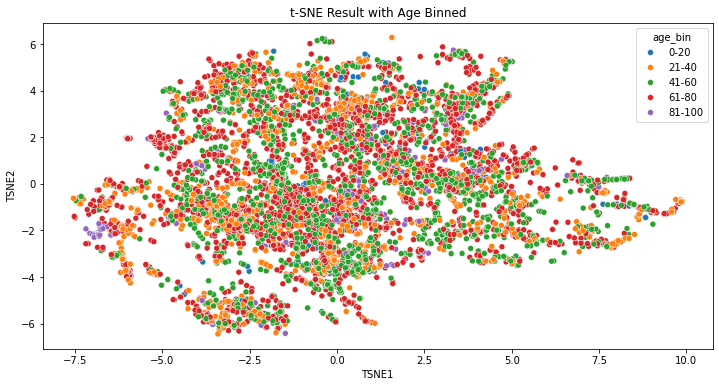

In [64]:

# Define age bins
bins = [0, 20, 40, 60, 80, 100]  # Define bins for age ranges
labels = ['0-20', '21-40', '41-60', '61-80', '81-100']  # Define bin labels
tsne_df['age_bin'] = pd.cut(tsne_df['age'], bins=bins, labels=labels)

# Plot PCA result with discrete age bins
plt.figure(figsize=(12, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='age_bin', data=tsne_df,) #coolwarm, plasma, viridis
plt.title('t-SNE Result with Age Binned')
plt.show()


##### t-SNE 2D scatter plot colored by site

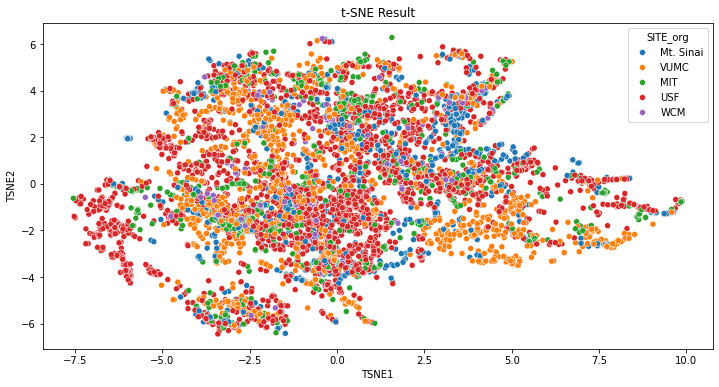

In [55]:
# Plot t-SNE result
#plt.subplot(1, 2, 2)
plt.figure(figsize=(12, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='SITE_org', data=tsne_df)
plt.title('t-SNE Result')
plt.show()

##### t-SNE 3D scatter plot colored by age

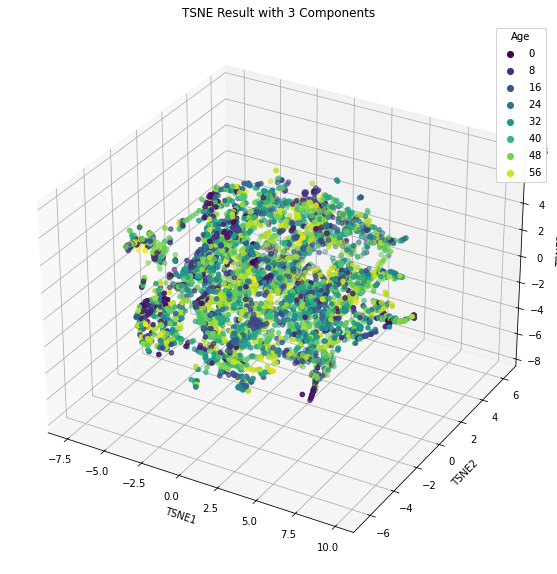

In [53]:

#prepare the data for plotting 2D scatter plot of PCA features
tsne_df = pd.DataFrame(tsne_result[:,:3], columns=['TSNE1', 'TSNE2', 'TSNE3'])
tsne_df = pd.concat([tsne_df, opensmile_df[['age', 'GENDER_org', 'SITE_org']].reset_index(drop=True)], axis=1)

#Plot TSNE 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], tsne_df['TSNE3'], c=tsne_df['age'].astype('category').cat.codes, cmap='viridis')

# Add legend
legend1 = ax.legend(*scatter.legend_elements(), title="Age")
ax.add_artist(legend1)

# Add labels
ax.set_xlabel('TSNE1')
ax.set_ylabel('TSNE2')
ax.set_zlabel('TSNE3')
plt.title('TSNE Result with 3 Components')
plt.show()

#### Correlation heatmap

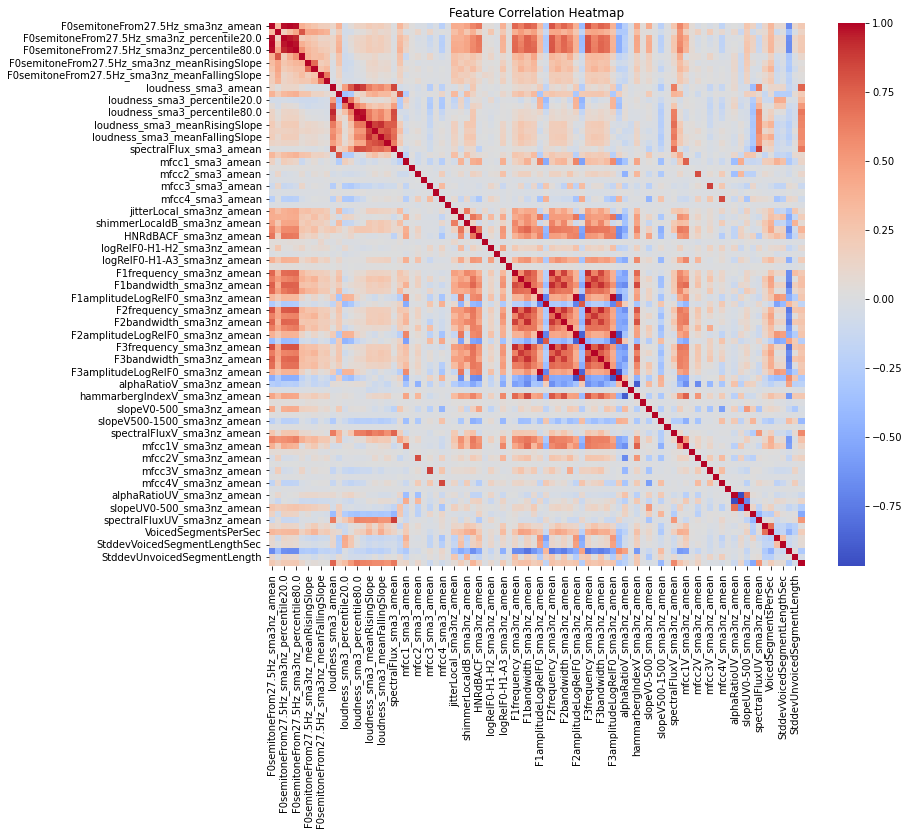

In [54]:
# Correlation Heatmap
corr_matrix = pd.DataFrame(scaled_features, columns=feature_columns).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

#### Scree plot PCA

In [ ]:

'''
## Acknowledgements
Special thanks to ChatGPT for providing code snippets and guidance for the implementation of various techniques in this project. 
[OpenAI’s ChatGPT](https://www.openai.com/chatgpt) was instrumental in generating code and answering questions about data analysis and 
visualization.
'''

# Perform PCA
pca_full = PCA(n_components=88)
pca_result = pca_full.fit_transform(scaled_features)

#prepare the data for plotting 2D scatter plot of PCA features
#pca_df = pd.DataFrame(pca_result)
#pca_df = pd.concat([pca_df, opensmile_df[['age', 'gender', 'site']].reset_index(drop=True)], axis=1)

variance_ratio= pca_full.explained_variance_ratio_

# Prepare data for plotting
x = np.arange(1, len(variance_ratio) + 1)
y = variance_ratio

# Cumulative explained variance
cumulative_variance = np.cumsum(variance_ratio)

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot explained variance
color = 'tab:blue'
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio', color=color)
ax1.plot(x, y, 'o-', color=color, label='Explained Variance Ratio')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot cumulative explained variance
ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Cumulative Explained Variance', color=color)
ax2.plot(x, cumulative_variance, 's-', color=color, label='Cumulative Explained Variance')
ax2.tick_params(axis='y', labelcolor=color)

# Adding legend
fig.tight_layout()  # To ensure the right y-label is not slightly clipped
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Adding titles and labels
plt.title('Scree Plot with Explained and Cumulative Variance')
plt.xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax2.set_ylabel('Cumulative Explained Variance')

# Annotate the point where 95% of variance is explained
# Annotate the point where 90%, 95%, and 99% of variance is explained
thresholds = [0.90, 0.95, 0.99]
for threshold in thresholds:
    num_components_to_threshold = np.argmax(cumulative_variance >= threshold) + 1
    ax2.axhline(y=threshold, color='g', linestyle='--', linewidth=0.7)
    ax2.axvline(x=num_components_to_threshold, color='g', linestyle='--', linewidth=0.7)
    ax2.annotate(f'{num_components_to_threshold} components explain {threshold * 100:.0f}% of variance',
                 xy=(num_components_to_threshold, threshold), xytext=(num_components_to_threshold + 5, threshold - 0.05),
                 arrowprops=dict(facecolor='black', shrink=0.05))


# Show the plot
plt.show()

In [ ]:
def calc_min_principle_comp_required(variance_ratio, variance_ratio_threshold):
  
  maintained_variance_ratio = 0.0
  n = 1

  while maintained_variance_ratio < variance_ratio_threshold:

    maintained_variance_ratio = sum(variance_ratio[:n])
    n+=1

  return n-1

In [ ]:
principal_component_count_90 = calc_min_principle_comp_required(variance_ratio, 0.90)

print(principal_component_count_90)

In [ ]:
principal_component_count_95 = calc_min_principle_comp_required(variance_ratio, 0.95)

print(principal_component_count_95)

In [ ]:
principal_component_count_99 = calc_min_principle_comp_required(variance_ratio, 0.99)

print(principal_component_count_99)

#### Scree plot t-SNE

In [ ]:
'''
## Acknowledgements
Special thanks to ChatGPT for providing code snippets and guidance for the implementation of various techniques in this project. 
[OpenAI’s ChatGPT](https://www.openai.com/chatgpt) was instrumental in generating code and answering questions about data analysis and 
visualization.
'''

# Define perplexity values
perplexities = [5, 20, 30, 40, 50]

# Create subplots
fig, axes = plt.subplots(1, 5, figsize=(25, 10))

for i, perplexity in enumerate(perplexities):
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=300)
    tsne_result = tsne.fit_transform(scaled_features)
    
    # Create DataFrame for plotting
    #tsne_df = pd.DataFrame(tsne_result, columns=['TSNE1', 'TSNE2'])
    tsne_df = pd.DataFrame(tsne_result, columns=['TSNE1', 'TSNE2'])
    tsne_df = pd.concat([tsne_df, opensmile_df[['age', 'gender', 'site']].reset_index(drop=True)], axis=1)
    tsne_df['perplexity'] = perplexity
    
    # Plot
    sns.scatterplot(x='TSNE1', y='TSNE2', hue='gender', data=tsne_df, ax=axes[i])
    #sns.scatterplot(x='TSNE1', y='TSNE2', data=tsne_df, ax=axes[i])
    axes[i].set_title(f't-SNE with Perplexity={perplexity}')
    axes[i].set_xlabel('TSNE1')
    axes[i].set_ylabel('TSNE2')

plt.tight_layout()
plt.show()


# Test cells (ignore those)

In [ ]:

x = torch.load('./data/bids_with_sensitive_recordings/sub-0ee1e1e1-0e86-42cc-9e9d-2cafd9f1e01c/ses-CC0EE711-2FC3-43D5-B7FF-21424F748985/audio/sub-0ee1e1e1-0e86-42cc-9e9d-2cafd9f1e01c_ses-CC0EE711-2FC3-43D5-B7FF-21424F748985_Diadochokinesis_rec-Diadochokinesis-Pataka.pt')

x.keys()

In [ ]:
print(type(x['opensmile']['equivalentSoundLevel_dBp']))
print(type(x['opensmile']))
print(x['opensmile']['equivalentSoundLevel_dBp'].shape)
print(x['opensmile'].shape)

In [ ]:
print(len(list(x['opensmile'].columns)))

In [ ]:
for ftr in x['opensmile']:
    print(type(x['opensmile'][ftr]))

In [ ]:
print(x['opensmile'].shape, type(x['opensmile']))
for ftr in x['opensmile']:
    print(type(ftr), ftr)

In [ ]:
qs = dataset_sample.load_questionnaires('recordingschema')

print(len(qs))
#print(qs[0].json(indent=2))

In [ ]:
demographics_df = dataset.load_and_pivot_questionnaire('qgenericdemographicsschema')
print(demographics_df.shape)
#print(demographics_df.columns)
demographics_df_uniq = demographics_df.drop_duplicates(subset='record_id', keep='first')
print(demographics_df_uniq.shape)

#print("Duplicates : ", demographics_df[demographics_df.duplicated(subset='record_id')]['record_id'].to_list())

participant_df = dataset.load_and_pivot_questionnaire('participant')

ids_in_participant_not_demographic = participant_df.set_index('record_id').index.difference(demographics_df_uniq.set_index('record_id').index)

#print(ids_in_participant_not_demographic.to_list())

#duplicate_demographics_record = ['01401050-e9dd-486e-b0d4-0001ee7f861d', 'd554cc1a-efe5-4b7a-a77b-f5abca8846bd', '771fb46d-e94a-4129-ab3d-32cadf92c6f0']
#no_demographics_record = ['2af5afbc-82b1-4656-a203-a8d29b69d3ab', '5201d61d-4b67-482f-bddd-39466e63c4f4']

#df = pd.read_csv('/home/mithrandir/Documents/Summer school/data/demographics.csv')

#print(df.shape)
demographics_df = dataset.load_and_pivot_questionnaire('qgenericdemographicsschema').drop_duplicates(subset='record_id', keep='first')[['record_id', 'gender_identity']]
print(demographics_df.shape)
row1 = {'record_id': no_demographics_record[0], 'gender_identity': 'no record'}
row1 = {'record_id': no_demographics_record[1], 'gender_identity': 'no record'}

new_row_df = pd.DataFrame({'record_id': no_demographics_record, 'gender_identity': ['no record', 'no record']})

demographics_df = pd.concat([demographics_df,new_row_df], ignore_index=True).sort_values(by='record_id').to_numpy()
print(demographics_df.shape)
